## 기본 설정

아래에 사용한 모듈들은 추가 및 제거가 가능

In [1]:
import monai

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# for image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob

from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

In [2]:
dir = 'D:/python_study/'
# 디렉토리 설정으로 가장 상위 디렉토리를 권장

In [3]:
image = sorted(glob.glob(os.path.join(dir, 'image', '*.png')))
mask = sorted(glob.glob(os.path.join(dir, 'filled_label', '*.png')))

# glob.glob를 이용하여 좀 더 간단하게 접근
# 차후 이미지의 개수를 기준으로 폴더를 나눔

In [6]:
loader = monai.transforms.LoadImage(monai.data.PILReader(converter=lambda image: image.convert("RGBA")))

# 모나이에서 지원하는 이미지 로더를 사용하며, RGBA 4 채널을 사용 

## Used Functions

아래에서 기능의 형태로 사용한 함수들을 한곳에 정리

폴더 생성, 폴더 하위의 파일과 그에 관련한 레이블 생성 함수

폴더 생성 : os.makedirs를 이용하여 원하는 폴더(디렉토리)가 없는 경우 생성

파일과 레이블 생성 : 폴더 번호를 입력 받아 그 하위에 있는 파일과 파일에 해당하는 레이블을 생성

In [7]:
def create(dir):
    try:
        if not os.path.exists(dir):
            os.makedirs(dir)
    except:
        print('Error : creating directory. ' + dir) # 오류가 발생하는 경우 메세지 출력

In [8]:
def files_and_labels(folder_type):

    files = []
    labels = []

    for i in folder_type:

        files += glob.glob(os.path.join(dir, 'patches/*', f'img{i+1:02d}', '*.png')) # 폴더(디렉토리) 번호에 해당하는 폴더 하위 파일들을 리스트의 형태로 반환  

    for file in files: # 파일들 경로에 'cancer'란 단어가 있는 경우 0, 없는 경우 1을 지정
        if 'cancer' in file:
            labels.append(0)
        else:
            labels.append(1)

    return files, labels

In [9]:
patches = dir + '/patches'
d_cancer = patches + '/cancer'
d_normal = patches + '/normal'

## Patch generate sequence

In [7]:
patch_size = (200,200)

# 패치 크기, 현재 200 * 200으로 설정

normal cells

In [ ]:
create(patches)
create(d_cancer)
create(d_normal)

pat_num = 1000

for k in range(len(image)):
    
    print(f'Processing image no.{k+1}')

    count = 0

    cancer_im = (f'{d_cancer}' + f'/img{k+1:02d}')

    create(cancer_im)

    img_file = image[k]
    mask_file = mask[k]

    image_data, image_meta = loader(img_file)
    mask_data, mask_meta = loader(mask_file)

    mtemp_position = []
    m_position = []
    
    x, y, z = np.where(mask_data/255 == 1)

    for m_pos in zip(x, y):
        lm_pos = list(m_pos)
        mtemp_position.append(lm_pos)

    for i in range(0, len(mtemp_position), 3):
        if mtemp_position[i][0]>=100 and mtemp_position[i][1]>= 100:
            m_position.append(mtemp_position[i])

    m_sample = random.sample(m_position, pat_num)

    for n in range(len(m_sample)):
        cancer = image_data[m_sample[n][0]-100:m_sample[n][0]+100, m_sample[n][1]-100:m_sample[n][1]+100, :] / 255
        plt.imsave(f'D:/python_study/patches/cancer/img{k+1:02d}/Image{k+1:02d}{n+1:04d}_abnormal.png', cancer)

In [ ]:
pat_num = 1000

for k in range(len(image)):
    
    print(f'Processing image no.{k+1}')

    count = 0

    normal_im = (f'{d_normal}' + f'/img{k+1:02d}')

    create(normal_im)

    itemp_position = []
    i_position = []

    img_file = image[k]
    mask_file = mask[k]

    image_data, image_meta = loader(img_file)
    mask_data, mask_meta = loader(mask_file)
      
    q, w, e = np.where((image_data/255 != 0) & (mask_data/255 == 0))

    for i_pos in zip(q, w):
        li_pos = list(i_pos)
        itemp_position.append(li_pos)

    for j in range(0, len(itemp_position), 3):
        if itemp_position[j][1]>=200:
            i_position.append(itemp_position[j])

    i_sample = random.sample(i_position, pat_num*5)

    for l in range(len(i_sample)):
        
        normal = image_data[i_sample[l][0]-200:i_sample[l][0], i_sample[l][1]-200:i_sample[l][1], :] / 255
        normal_mask = mask_data[i_sample[l][0]-200:i_sample[l][0], i_sample[l][1]-200:i_sample[l][1], :] / 255
        
        if sum(sum(sum(normal_mask == 0))) >= normal_mask.size*0.8:
            plt.imsave(f'D:/python_study/patches/normal/img{k+1:02d}/Image{k+1:02d}{l+1:04d}_normal.png', normal)
            count += 1

        if count == pat_num:
            break

## Dataset seqence

In [ ]:
# seed = 0

In [11]:
# train : valid : test === 6.5 : 2.5 : 1 의 비율로 시작 하였으나 변경 가능
 
valid_rat = 0.25
test_rat = 0.1

In [13]:
sample_num = len(image) # sample 수를 기준으로 데이터 비율 조정

train_c = int(sample_num * (1 - (valid_rat + test_rat)))
valid_c = int(sample_num * valid_rat)
test_c = int(sample_num * test_rat)

train_c, valid_c, test_c

(13, 5, 2)

In [14]:
folder_num = list(range(sample_num))

# 단순 앞에서부터 파일 번호 부여

In [15]:
folder_num

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [16]:
train_folder = folder_num[:train_c]
valid_folder = folder_num[train_c : train_c + valid_c]
test_folder = folder_num[-test_c:]

print(train_folder, '\n', valid_folder, '\n', test_folder)

# 생성된 폴더 번호를 데이터 비율에 맞게 분배

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
 [13, 14, 15, 16, 17] 
 [18, 19]


In [17]:
class_names = sorted(x for x in os.listdir(patches)
                     if os.path.isdir(os.path.join(patches, x)))

num_class = len(class_names)

# 클래스(레이블) 이름 지정
# 0 for cancer, 1 for normal

In [18]:
train_x, train_y = files_and_labels(train_folder)

val_x, val_y = files_and_labels(valid_folder)

test_x, test_y = files_and_labels(valid_folder)

# 데이터 분류
# 위에 정의한 함수를 통해 하위 파일과, 파일에 해당하는 레이블을 가져옴

이미지 크기 확인 코드

In [53]:
for item in train_x:
    if loader(item)[0].shape != (200,200,4):
        print(item)

In [45]:
for item in val_x:
    if loader(item)[0].shape != (200,200,4):
        print(item)

In [46]:
for item in test_x:
    if loader(item)[0].shape != (200,200,4):
        print(item)

## Model Training sequence

기존에 사용하던 모델 학습 기법을 사용

학습 모델 및 여러가지를 변경하여 사용할수 있음

In [19]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        # AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5), 
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5), 
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

In [20]:
# 모델에 입력하기 위한 training, validation 또는 test 데이터셋 생성하기 위한 class선언

class MedNISTDataset(torch.utils.data.Dataset): #상속함 ()안에들어있는거
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

# data_loader 정의(DataLoader = 데이터셋과 샘플러를 결합하고 사용 가능한 데이터셋을 제공합니다.)
# num_workers = 학습 도중 CPU의 작업을 몇 개의 코어를 사용해서 진행할지에 대한 설정 파라미터입니다
# num_workers = 0로 할 경우 모든 코어를 사용하여 진행

train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=10, shuffle=True, num_workers=0)
    # 코드가 멈추는 경우 배치 사이즈를 줄여서 코드 실행

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=10, num_workers=0)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=10, num_workers=0)

In [33]:
device = torch.device("cuda:0") # 저장한 모델을 gpu에서 불러올 때
                                # gpu가 없는 경우 cuda:0 대신 cpu를 사용 가능 하나 권장 하지 않음

model = DenseNet121(spatial_dims=2, in_channels=4, #DenseNet은 CNN 아키텍쳐 중 하나
                    out_channels=num_class).to(device) # out_channels = 출력 채널 수
                    
loss_function = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), 18e-5) # learning rate
max_epochs = 6
val_interval = 1
auc_metric = ROCAUCMetric() # AUC: ROC 곡선 아래 영역 / AUC 계산 metric

학습이 제대로 안되는 경우 에폭수를 좀더 줄여야 함

In [34]:
best_metric = -1    
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs): 
    print("-" * 10)         #구분선
    print(f"epoch {epoch + 1}/{max_epochs}") #몇번째 epoch인지 출력
    model.train()           # 모델 학습
    epoch_loss = 0          # epoch_loss(epoch의 average loss) 초기화
    step = 0                # step 초기화
    for batch_data in train_loader: # train_loader에서 train데이터에 대한 정보가져옴
        step += 1
        inputs, labels = batch_data[0].permute(0,3,1,2).to(device), batch_data[1].to(device)
        optimizer.zero_grad() #Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문"에 우리는 항상 backpropagation을 하기전에 gradients를 zero로 만들어주고 시작을 해야합니다
        outputs = model(inputs)
        loss = loss_function(outputs, labels) #lossfuction으로 loss 계산
        loss.backward() #현재 tensor의 gradient를 계산
        optimizer.step() #
        epoch_loss += loss.item() #train_loss 값을 epoch_loss에 더해서 저장
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "# train데이터를 batch size로 나눈 값
            f"train_loss: {loss.item():.4f}") # train loss
        epoch_len = len(train_ds) // train_loader.batch_size #epoch수 (47164 /300)
    epoch_loss /= step        # average loss는 전체 loss 값 더해준 것을 step으로 나눈 값
    epoch_loss_values.append(epoch_loss)  # epoch_loss값 리스트에 원소로 추가
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0: # epoch 한 번 돌았으면 나머지 수행
        model.eval()   # 모델 평가
        with torch.no_grad():    #gradinet 계산하지 않음
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].permute(0,3,1,2).to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate() #auc metric을 통해 auc 계산하고 result에 저장
            auc_metric.reset() #버퍼를 리셋한다
            del y_pred_act, y_onehot #del은 파이썬 어레이의 요소를 삭제
            metric_values.append(result) #auc값 list에 추가
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:  #best_metric보다 auc크다면 result로 best_metric값 업데이트
                best_metric = result  #
                best_metric_epoch = epoch + 1 
                torch.save(model.state_dict(), os.path.join(  #root_dir에 모델의 weight를 저장
                    dir, "best_metric_model2.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/6
1/2595, train_loss: 0.6836
2/2595, train_loss: 0.8108
3/2595, train_loss: 0.5463
4/2595, train_loss: 0.4855
5/2595, train_loss: 0.6860
6/2595, train_loss: 0.6312
7/2595, train_loss: 0.5491
8/2595, train_loss: 0.6293
9/2595, train_loss: 0.5219
10/2595, train_loss: 0.5537
11/2595, train_loss: 0.7100
12/2595, train_loss: 0.6166
13/2595, train_loss: 0.8749
14/2595, train_loss: 0.4511
15/2595, train_loss: 0.2629
16/2595, train_loss: 0.6473
17/2595, train_loss: 0.6939
18/2595, train_loss: 0.8364
19/2595, train_loss: 0.5316
20/2595, train_loss: 0.3990
21/2595, train_loss: 0.3144
22/2595, train_loss: 0.3079
23/2595, train_loss: 0.4176
24/2595, train_loss: 0.6084
25/2595, train_loss: 0.8153
26/2595, train_loss: 0.2404
27/2595, train_loss: 0.5262
28/2595, train_loss: 0.2907
29/2595, train_loss: 0.4980
30/2595, train_loss: 0.4074
31/2595, train_loss: 0.5556
32/2595, train_loss: 0.5151
33/2595, train_loss: 0.8170
34/2595, train_loss: 0.6786
35/2595, train_loss: 0.5902
36/2595,

학습 결과 확인

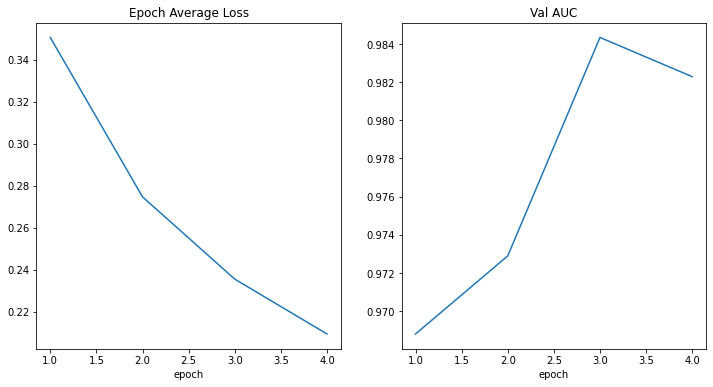

In [23]:
plt.figure("train", (12, 6)) #
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))] #0부터 eppch_loss가 계산된 횟수까지 리스트에 저장
y = epoch_loss_values #epoch_loss값
plt.xlabel("epoch") #축은 epoch
plt.plot(x, y) 
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))] #0에서 epoch수까지 1을 더해서 가져와서 validation interval과 곱함
y = metric_values #epoch별 AUC값
plt.xlabel("epoch") #축은 epoch
plt.plot(x, y)
plt.show()

In [22]:
model.load_state_dict(torch.load(
    os.path.join(dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (  #test_image와 test_label을 가져옴
            test_data[0].permute(0, 3, 1, 2).to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1) #차원에서 텐서의 최대값 인덱스를 반환합니다.
        for i in range(len(pred)):
            y_true.append(test_labels[i].item()) # 정답들을 저장
            y_pred.append(pred[i].item())        # 모델이 예측한 값들을 저장

In [23]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

      cancer     0.9385    0.9383    0.9384      4000
      normal     0.9383    0.9385    0.9384      4000

    accuracy                         0.9384      8000
   macro avg     0.9384    0.9384    0.9384      8000
weighted avg     0.9384    0.9384    0.9384      8000



## Inference sequnce

확인하기 위한 이미지 불러오기

In [ ]:
infer_img = loader(image[0])
infer_mask = loader(mask[0])

# 위에서 선언한 image 중 첫번째 이미지 사용

모델과 학습 결과를 불러와 적용

In [ ]:
model.load_state_dict(torch.load(os.path.join(dir, "best_metric_model.pth")))
model.eval()

무색의 히트맵을 만들 이미지 생성

In [ ]:
heat_map = np.zeros((height, width))

In [ ]:
def softmax(a) :
    y = []
    c,n = a
    exp_c = np.exp(c)
    exp_n = np.exp(n)
    sum_exp_a = exp_c + exp_n
    C = exp_c / sum_exp_a
    N = exp_n / sum_exp_a

    y.append(C)
    y.append(N)

    y = np.array(y)

    return y        

In [ ]:
color_range2 = []

for j in range(0,(height - 200), 50):
    for i in range(0,(width - 200), 50):
        
        patch2 = img[j:j+200, i:i+200, :] / 255
        patch2 = torch.tensor(patch2.reshape((1,) + patch2.shape)).permute(0,3,1,2).to(device)

        y_p2 = model(patch2)[0].cpu().detach().numpy()
        soft_y2 = softmax(y_p2)

        heat_map[j:j+200, i:i+200] = soft_y2[0]

        color_range.append(soft_y2[0])

원본 이미지와 히트맵을 겹쳐서 확인 함으로 성능 확인

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(img/255)
plt.imshow(heat_map, cmap='jet', alpha = 0.6)
plt.clim(min(color_range), max(color_range))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(label/255)

plt.show()

## Do not open

In [ ]:
la = torch.tensor([0]).to(device)

        loss = int(loss_function(y_p, la).item())

        # print(loss)

        # 0 2 4 6
        if loss <= 0:
            # 암으로 판단되는 셀을 희색으로 변경
            hit_map[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)), :] = [255,0,0,1]
        elif (loss >= 2 and loss < 4):
            hit_map[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)), :] = [255,0,0,0.8]
        elif (loss >= 4 and loss < 5):
            hit_map[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)), :] = [255,0,0,0.6]
        else:
            pass
            # hit_map[((height//h)*j):((height//h)*(j+1)),((width//w)*i):((width//w)*(i+1)), :] = [0,0,0,1]

In [31]:
from PIL import Image

test = Image.open('D:/python_study/patches/normal/img01/Image010001_normal.png')

pix = np.array(test.getdata())

In [32]:
pix.shape

(40000, 4)